In [1]:
import nltk
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix
import seaborn as sn
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import cross_val_score
from sklearn import svm
import gensim
from gensim.utils import simple_preprocess
from nltk.corpus import gutenberg 
import urllib.request
import re
from nltk.stem.porter import PorterStemmer
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import  LatentDirichletAllocation as LDA
from sklearn import mixture
from gensim import corpora, models
import pyLDAvis
# import pyLDAvis.gensim
import pyLDAvis.gensim_models as gensimvis
from copy import deepcopy
from sklearn.metrics.cluster import adjusted_rand_score

In [2]:
nltk.download('stopwords')
nltk.download('gutenberg')
!pip install pyLDAvis
import warnings
warnings.filterwarnings('ignore')

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

C:\Users\Mans\anaconda3_v2\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mans\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\Mans\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


# **Performance function draw confusion matrix and calculate accuracy**

In [3]:
def performance(y,y_predict):
    print('Confusion matrix\n')
    hm=sn.heatmap(confusion_matrix(y,y_predict), annot=True)
    plt.show()
    counter=0
    comp=[]
    for i in range(len(y)):
        if y[i]!=y_predict[i]:
            counter+=1
            comp.append(0)
        else:
            comp.append(1)

    comp=np.array(comp)
    score=(1-counter/len(y))*100
    print('Score',score,'%')
    return score

# **Book segmentation function clean, tokenize, and generate random samples**

In [4]:
def book_segmentation(book, book_name,size,ln):
    #function to segment book to  200 random sample of 100 words
    #this tokenizer with regular expression to remove punctuation so ensure that you have only words
    tokenizer = nltk.RegexpTokenizer(r"\w+")
    tokenized_words=tokenizer.tokenize(book)
    offset = 0
    stop_words=set(stopwords.words("english"))
    filtered_sents=[]
    for w in tokenized_words:#is this wrong and should be tokenized_word?
        if w.lower() not in stop_words:
            filtered_sents.append(w.lower())
    
    porter = PorterStemmer()        
    stems = []
    for t in filtered_sents:    
        stems.append(porter.stem(t))  
        
    pages = []
    offset=200
    for i in range(size):
        #generate random number from 0 to words count - 100 to be starting point of segment
        offset+=np.random.randint(0,50)
        pages.append({'book_name': book_name,
                      'partition': " ".join(stems[offset:offset+ln])+" "})          
    return pages

# **Reading books and generate 200 samples of 100 word**

In [5]:
urls = [['https://www.gutenberg.org/cache/epub/3623/pg3623.txt','0'],
         ['https://www.gutenberg.org/cache/epub/24681/pg24681.txt','1'],
         ['https://www.gutenberg.org/cache/epub/29444/pg29444.txt','2'],
         ['https://www.gutenberg.org/cache/epub/19528/pg19528.txt','3'], 
         ['https://www.gutenberg.org/files/20/20-0.txt','4']]
books_names = ['The Golden Bough', 'Opportunities in Engineering','The Machinery of the Universe','Sixty Years of California Song', 'Paradise Lost']

book_pages=[]
for url,book_name in urls:
    book = urllib.request.urlopen(url).read().decode('utf8')
    book = re.sub('[^a-zA-Z]',' ', book )
    book_pages+=book_segmentation(book, book_name,200,150)    

# **Split data extracted from books to features and labels**

In [6]:
books_df= pd.DataFrame(book_pages)
# print(books_df)
df_x=pd.DataFrame(books_df['partition'])
df_y=pd.DataFrame(books_df['book_name'])

# **Vectorize function apply BOW and tfidf transformation on dataset**

In [7]:
def vectorize():
    # Creating a corpus of all 5 books
    corpus = []
    for i in range(0, 1000):
        review = re.sub('[^a-zA-Z]',' ', df_x['partition'][i]) #this will only keep letters from A-z and will remove any numbers and puntuation
        review = review.lower()# this will convert all letters to lower cases
        reviewer = " ".join(review.split())# remove white spaces
        corpus.append(reviewer)
    
    # Creating the Bags of Words Model
    CountVec = CountVectorizer(ngram_range=(1,1))
    #transform
    Count_data = CountVec.fit_transform(corpus)
    #create dataframe
    BOW_dataframe=pd.DataFrame(Count_data.toarray())
    Y = CountVec.get_feature_names()
    
    yvec = books_df.iloc[:, 0]
    yvecs = pd.DataFrame(yvec)
    #Encoding categorical data
    from sklearn.preprocessing import LabelEncoder
    labelencoder_y = LabelEncoder()
    yvec=labelencoder_y.fit_transform(yvec)
      

    #Td-if
    X_tf = TfidfVectorizer()
    X_tfd =  X_tf.fit_transform(corpus).toarray()
    X_tfd = pd.DataFrame(X_tfd)
    
    # Applying LDA
    lda = LDA(n_components = 10, max_iter=10, n_jobs = -1, batch_size=128, learning_decay=0.5)
    lda.fit_transform(BOW_dataframe)
    X_lda = lda.fit_transform(BOW_dataframe)
    X_LDa = pd.DataFrame(X_lda)

    return X_tfd, BOW_dataframe, X_LDa, corpus, CountVec, yvec, X_lda, Y

X_tfd,BOW_dataframe,X_LDa,corpus,CountVec,yvec,X_lda,Y =vectorize()

# Build Clusters with Gaussian Mixture Models using the EM algorithm for finding the right model parameters

In [8]:
gaussianbow = mixture.GaussianMixture(n_components = 5, covariance_type = 'full')
gaussianbow.fit(BOW_dataframe)
gaussianpredbow = gaussianbow.fit_predict(BOW_dataframe)

gaussian = mixture.GaussianMixture(n_components = 5, covariance_type = 'full')
gaussian.fit(X_tfd)
gaussianpred = gaussian.fit_predict(X_tfd)

gaussianlda = mixture.GaussianMixture(n_components = 5, covariance_type = 'full')
gaussianlda.fit(X_lda)
gaussianpredlda = gaussian.fit_predict(X_lda)

# data values of each trasnformation algorithms

In [9]:
Xbow_cluster = BOW_dataframe.iloc[:, 0:BOW_dataframe.size].values
Xtf_cluster = X_tfd.iloc[:, 0:X_tfd.size].values
Xlda_cluster = X_LDa.iloc[:, 0:X_lda.size].values

# Applying Kmeans with k of 5 for each transformation algorithm

In [10]:
'''kmeans'''
from sklearn.cluster import KMeans

#kmeans with BOW
modelkmeansbow = KMeans(n_clusters=5)
modelkmeansbow.fit(Xbow_cluster)
y_kmeansbow = modelkmeansbow.fit_predict(Xbow_cluster)
y_kmeansbows = pd.DataFrame(y_kmeansbow)

#kmeans with TF
modelkmeanstf = KMeans(n_clusters=5)
modelkmeanstf.fit(Xtf_cluster)
y_kmeanstf = modelkmeanstf.fit_predict(Xtf_cluster)
y_kmeanstfs = pd.DataFrame(y_kmeanstf)


#kmeans with LDA
modelkmeanslda = KMeans(n_clusters=5)
modelkmeanslda.fit(X_LDa)
y_kmeanslda = modelkmeanslda.fit_predict(X_lda)
y_kmeanstfs = pd.DataFrame(y_kmeanstf)

order_centroidsbow = modelkmeansbow.cluster_centers_.argsort()[:, ::-1]
termsbow = CountVec.get_feature_names()

order_centroidstf = modelkmeanstf.cluster_centers_.argsort()[:, ::-1]
termstf = CountVec.get_feature_names()

order_centroidslda = modelkmeanslda.cluster_centers_.argsort()[:, ::-1]
termslda = CountVec.get_feature_names()

# Fitting Hierarchical Clustering to the dataset for each transformation algorithms

In [11]:
# Fitting Hierarchical Clustering to the dataset for BOW
from sklearn.cluster import AgglomerativeClustering
hcbow = AgglomerativeClustering(n_clusters=5, affinity = 'euclidean', linkage = 'ward')
y_hcbow = hcbow.fit_predict(Xbow_cluster)

# Fitting Hierarchical Clustering to the dataset for TF-IDF
from sklearn.cluster import AgglomerativeClustering
hctf = AgglomerativeClustering( n_clusters=5, affinity = 'euclidean', linkage = 'ward')
y_hctf = hctf.fit_predict(Xtf_cluster)

# Fitting Hierarchical Clustering to the dataset for LDA
from sklearn.cluster import AgglomerativeClustering
hclda = AgglomerativeClustering( n_clusters=5, affinity = 'euclidean', linkage = 'ward')
y_hclda = hclda.fit_predict(Xlda_cluster)

# visualizing the output of the LDA

In [12]:
'''pyLDAvis'''
texts = [[word for word in document.lower().split() if word not in stop_words] for document in corpus]
all_tokens = sum(texts, [])
tokens_once = set(word for word in set(all_tokens) if all_tokens.count(word) == 1)
texts = [[word for word in text if word not in tokens_once] for text in texts]
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]
lda = models.LdaModel(corpus, id2word=dictionary, num_topics=10,passes=10)
pyLDAvis.enable_notebook()

vis = gensimvis.prepare(lda,corpus,dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.177995  0.084415       1        1  17.460873
6     -0.151798  0.003573       2        1  12.787952
4      0.182580  0.080133       3        1  11.349063
1     -0.063736 -0.053720       4        1  11.046387
5     -0.037126  0.088239       5        1   9.394821
2      0.197896 -0.090563       6        1   9.390799
7      0.183339 -0.055924       7        1   7.738964
8     -0.066904 -0.136341       8        1   7.652399
9     -0.106465 -0.113301       9        1   6.804526
3      0.040209  0.193490      10        1   6.374217, topic_info=        Term         Freq        Total Category  logprob  loglift
1938   engin  1357.000000  1357.000000  Default  30.0000  30.0000
2485  energi   657.000000   657.000000  Default  29.0000  29.0000
1674   ether   671.000000   671.000000  Default  28.0000  28.0000
126        n   447.000000   447.000000  Default  27.0000  27.0000
341   matter   660.000000   660.000000  Default  26.0000  26.0000
...      ...          ...          ...      ...      ...      ...
1003   peopl    29.990239   221.433790  Topic10  -5.7632   0.7537
600     upon    32.368621   565.607789  Topic10  -5.6868  -0.1078
951   famili    28.483709   175.572422  Topic10  -5.8147   0.9342
910     made    30.178510   419.557091  Topic10  -5.7569   0.1208
553    would    30.533397   540.232579  Topic10  -5.7452  -0.1203

[781 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
4602      6  0.936102  abject
252       4  0.953105  abridg
578       6  0.191814  absurd
578       9  0.767256  absurd
1624      1  0.800324  action
...     ...       ...     ...
1051      4  0.133684   youth
1051      6  0.634998   youth
1051      7  0.183815   youth
1051      8  0.050131   youth
482       7  0.914003     zum

[2281 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 7, 5, 2, 6, 3, 8, 9, 10, 4])

# PCA Plot for Bag of Words algorithm

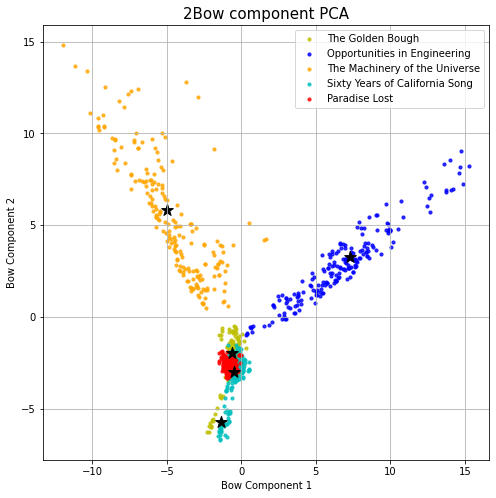

In [13]:
'''PCA plot'''

#kmeansbowPCA
from sklearn.decomposition import PCA
bow_pca = PCA(n_components=2)
BowComponents = bow_pca.fit_transform(BOW_dataframe)
BowDf = pd.DataFrame(data = BowComponents, columns = ['bow component 1', 'bow component 2'])

bow_centers = bow_pca.transform(modelkmeansbow.cluster_centers_)

n = BowComponents.shape[0]
centers_old = np.zeros(bow_centers.shape) # to store old centers
centers_new = deepcopy(bow_centers)

clusters = np.zeros(n)
distances = np.zeros((n,5))

error = np.linalg.norm(centers_new - centers_old)

while error != 0:
    # Measure the distance to every center
    for i in range(5):
        distances[:,i] = np.linalg.norm(BowComponents - bow_centers[i], axis=1)
    # Assign all training data to closest center
    clusters = np.argmin(distances, axis = 1)
    centers_old = deepcopy(centers_new)
    # Calculate mean for every cluster and update the center
    for i in range(5):
        centers_new[i] = np.mean(BowComponents[clusters == i], axis=0)
    error = np.linalg.norm(centers_new - centers_old)
centers_new 
centers_new = centers_new

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Bow Component 1', fontsize = 10)
ax.set_ylabel('Bow Component 2', fontsize = 10)
ax.set_title('2Bow component PCA', fontsize = 15)

colors = ['y', 'b', 'orange', 'c', 'r']  
for color, i, target_name in zip(colors, [0, 1, 2, 3, 4], books_names):
    ax.scatter(BowComponents[yvec == i, 0], BowComponents[yvec == i, 1], alpha=.8, color=color,
                label=target_name, s = 10)
ax.legend(loc='best', shadow=False, scatterpoints=1)
ax.scatter(centers_new[:,0], centers_new[:,1], marker='*', c='k', label = 'centroid', s=150)
ax.grid()





# PCA Plot for tfd 

Top terms per cluster:


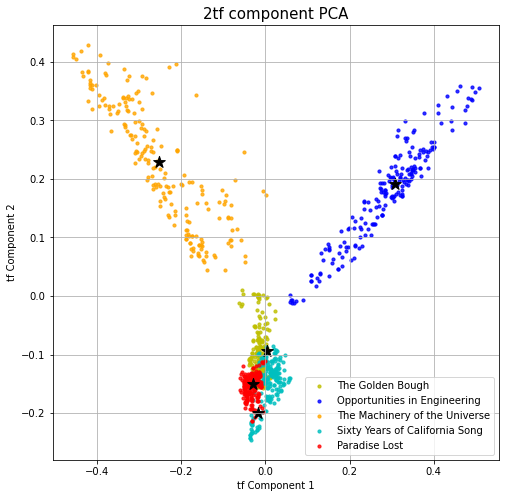

In [14]:
#kmeanstfPCA
tf_pca = PCA(n_components=2)
tfComponents = tf_pca.fit_transform(X_tfd)

tf_centers = tf_pca.transform(modelkmeanstf.cluster_centers_)

n = tfComponents.shape[0]
centers_old = np.zeros(tf_centers.shape) # to store old centers
centers_new = deepcopy(tf_centers)

clusters = np.zeros(n)
distances = np.zeros((n,5))

error = np.linalg.norm(centers_new - centers_old)

while error != 0:
    # Measure the distance to every center
    for i in range(5):
        distances[:,i] = np.linalg.norm(tfComponents - tf_centers[i], axis=1)
    # Assign all training data to closest center
    clusters = np.argmin(distances, axis = 1)
    centers_old = deepcopy(centers_new)
    # Calculate mean for every cluster and update the center
    for i in range(5):
        centers_new[i] = np.mean(tfComponents[clusters == i], axis=0)
    error = np.linalg.norm(centers_new - centers_old)
centers_new 
centers_new = centers_new

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('tf Component 1', fontsize = 10)
ax.set_ylabel('tf Component 2', fontsize = 10)
ax.set_title('2tf component PCA', fontsize = 15)

colors = ['y', 'b', 'orange', 'c', 'r']  
for color, i, target_name in zip(colors, [0, 1, 2, 3, 4], books_names):
    ax.scatter(tfComponents[yvec == i, 0], tfComponents[yvec == i, 1], alpha=.8, color=color,
                label=target_name, s = 10)
ax.legend(loc='best', shadow=False, scatterpoints=1)
ax.scatter(centers_new[:,0], centers_new[:,1], marker='*', c='k', label = 'centroid', s=150)
ax.grid()

print("Top terms per cluster:")

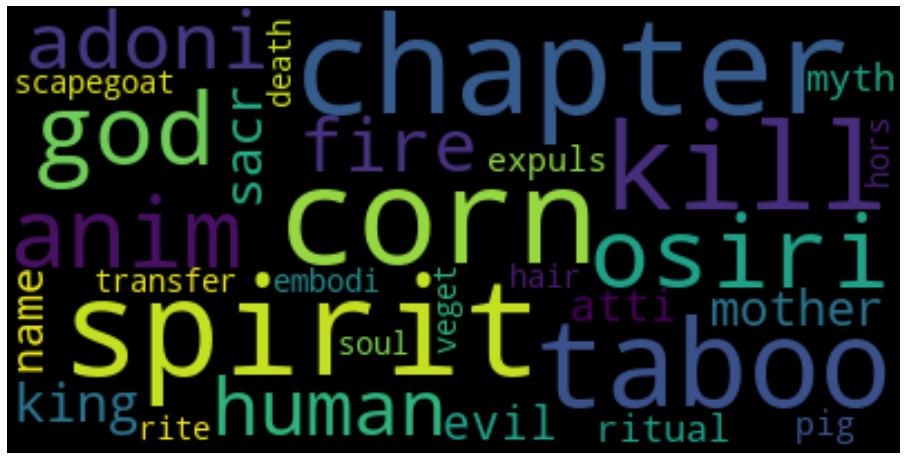

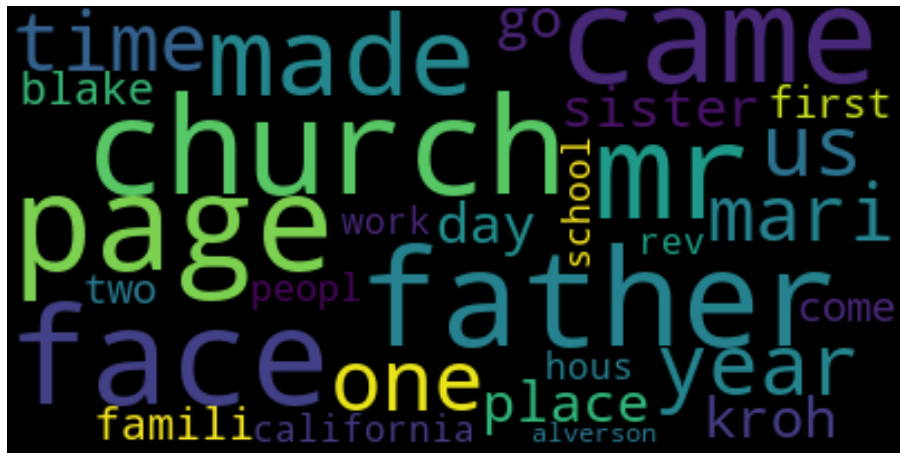

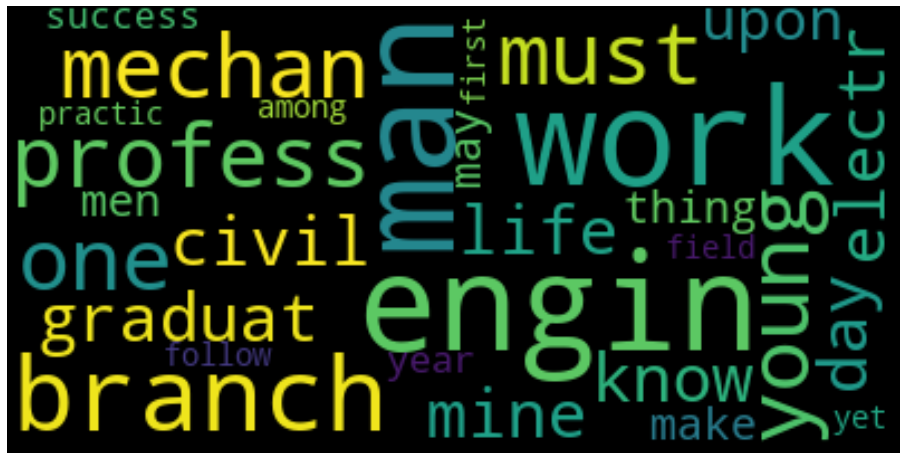

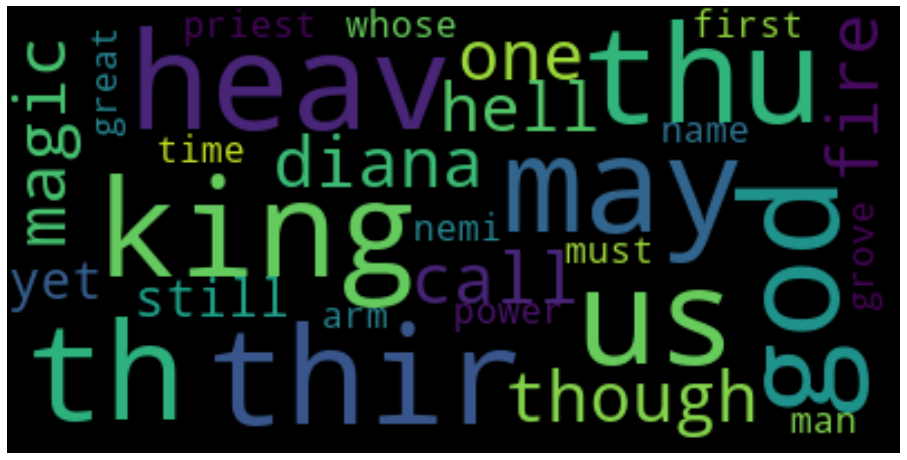

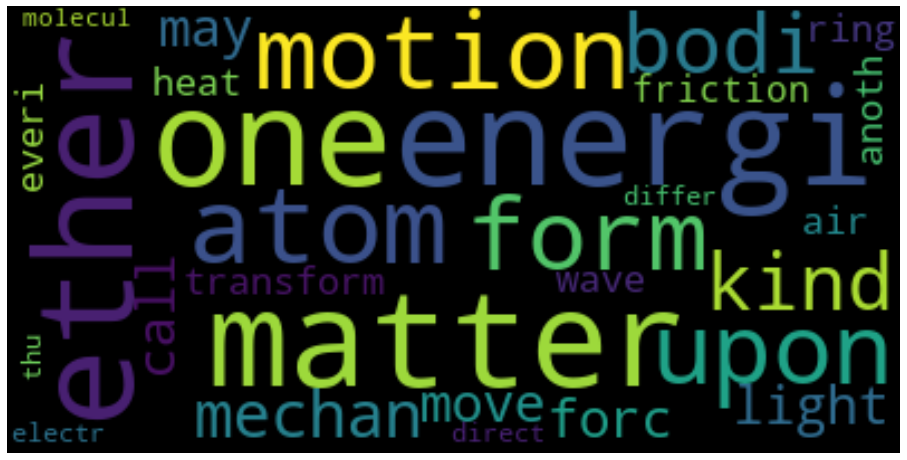

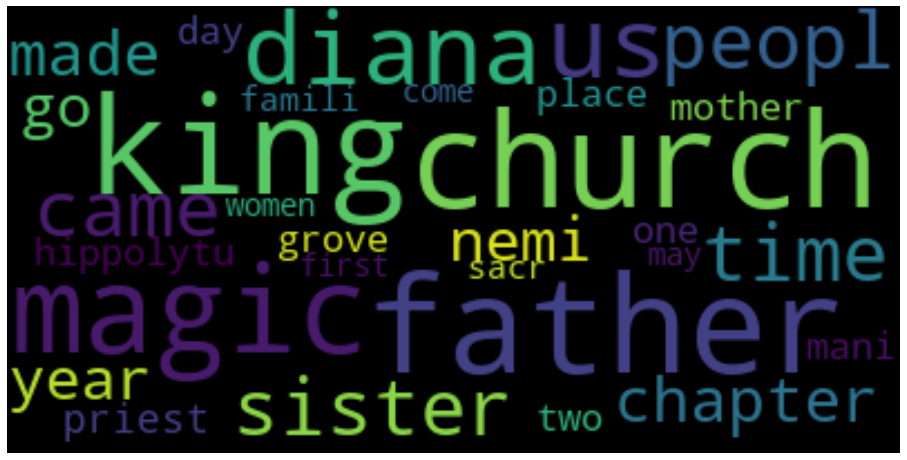

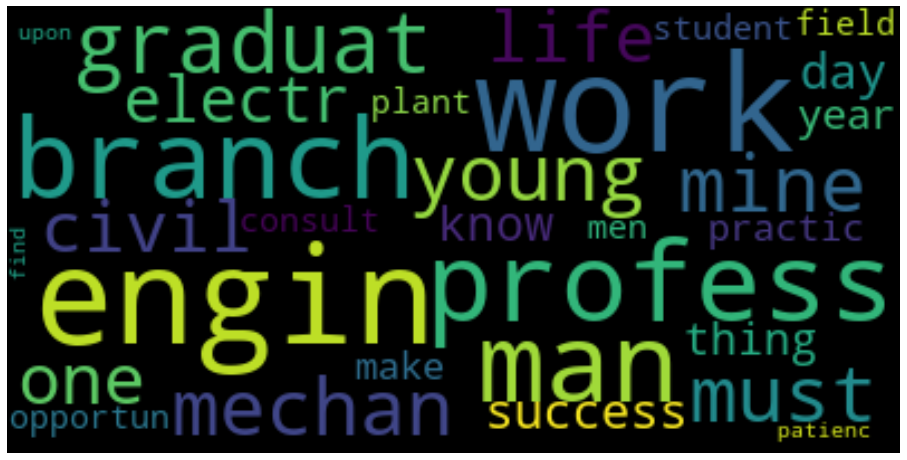

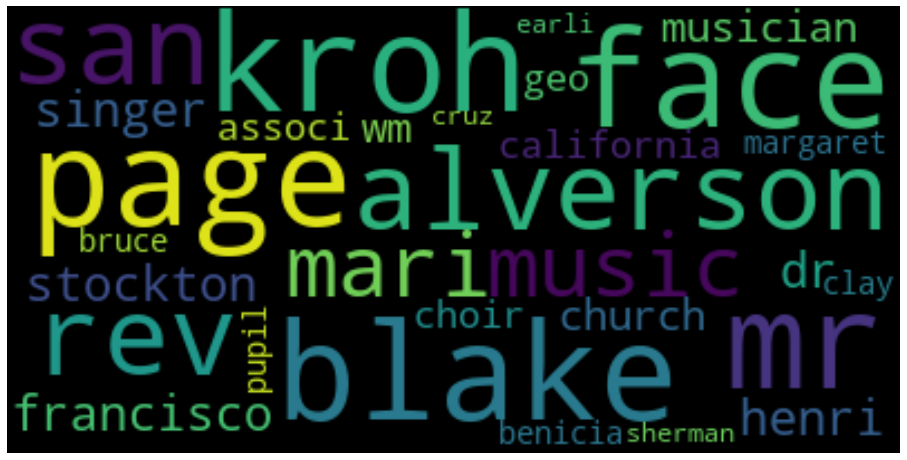

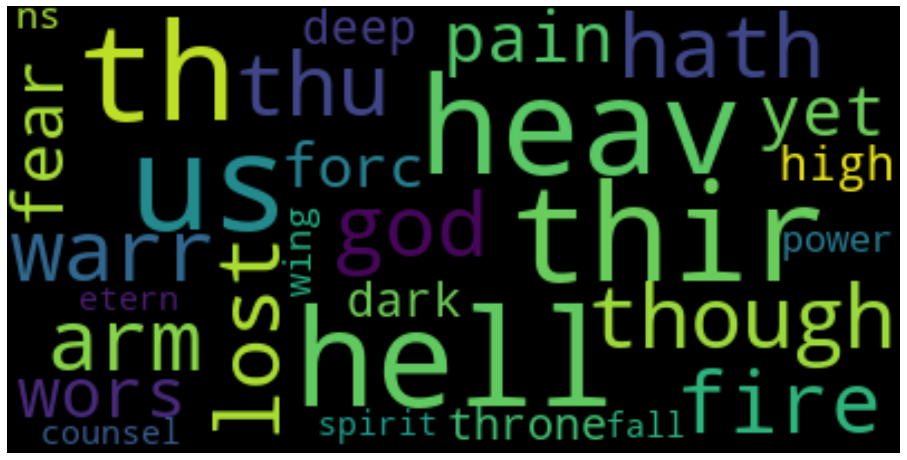

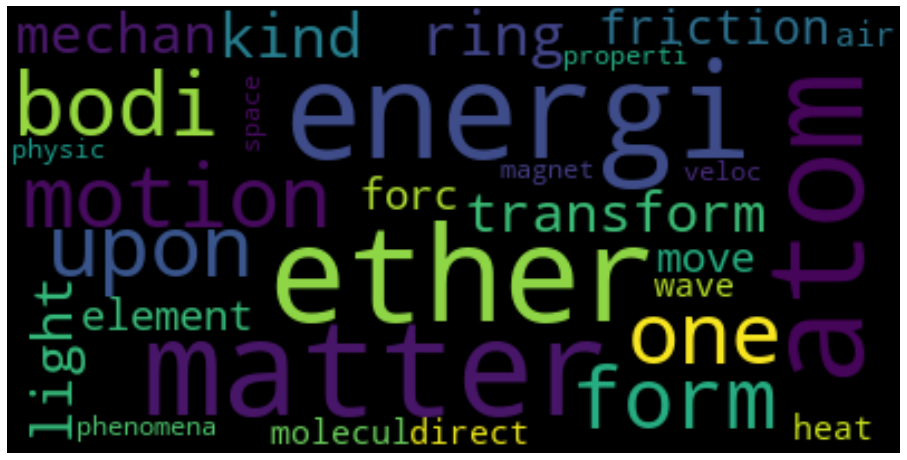

In [15]:
'''WordCloud'''

#bow
clusterz = []
order_centroids = modelkmeansbow.cluster_centers_.argsort()[:, ::-1]
for i in range(5):
    #print ("Cluster %d:" % i)
    clust = []
    for ind in order_centroids[i, :30]:
        clust.append(Y[ind])
    
    clusterz.append(' '.join(str(''.join(str(x) for x in v)) for v in clust))

for i in range(len(clusterz)):
    clusterwords = "".join(str(x) for x in clusterz[i])
    wordcloud = WordCloud(max_font_size = 60).generate(clusterwords)
    plt.figure(figsize=(16,12))
    plt.imshow(wordcloud, interpolation = "bilinear")
    plt.axis("off")
    plt.show()

#tf
clusterztf = []
order_centroids = modelkmeanstf.cluster_centers_.argsort()[:, ::-1]
for i in range(5):
    #print ("Cluster %d:" % i)
    clusttf = []
    for ind in order_centroids[i, :30]:
        clusttf.append(Y[ind])
    
    clusterztf.append(' '.join(str(''.join(str(x) for x in v)) for v in clusttf))

for i in range(len(clusterztf)):
    clusterwordstf = "".join(str(x) for x in clusterztf[i])
    wordcloudtf = WordCloud(max_font_size = 60).generate(clusterwordstf)
    plt.figure(figsize=(16,12))
    plt.imshow(wordcloudtf, interpolation = "bilinear")
    plt.axis("off")
    plt.show()

# Evaluation and error analysis

In [25]:
#silhouette
from sklearn.metrics import silhouette_score
silhouette_bow_kmeans = (silhouette_score(Xbow_cluster, y_kmeansbow, metric='euclidean'))
silhouette_tf_kmeans = (silhouette_score(Xtf_cluster, y_kmeanstf, metric='euclidean'))
silhouette_lda_kmeans = (silhouette_score(Xlda_cluster, y_kmeanslda, metric='euclidean'))
silhouette_agg_bow = (silhouette_score(Xbow_cluster, y_hcbow, metric='euclidean'))
silhouette_agg_tf = (silhouette_score(Xtf_cluster, y_hctf, metric='euclidean'))
silhouette_agg_lda = (silhouette_score(Xlda_cluster, y_hclda, metric='euclidean'))
silhouette_gaubow = (silhouette_score(Xbow_cluster, gaussianpredbow, metric='euclidean'))
silhouette_gautf = (silhouette_score(Xtf_cluster, gaussianpred, metric='euclidean'))
silhouette_gaulda = (silhouette_score(Xlda_cluster, gaussianpredlda, metric='euclidean'))


print(silhouette_bow_kmeans)
print(silhouette_tf_kmeans)
print(silhouette_lda_kmeans)
print(silhouette_agg_bow)
print(silhouette_agg_tf)
print(silhouette_agg_lda)
print(silhouette_gaubow)
print(silhouette_gautf)
print(silhouette_gaulda)


0.0571980626134078
0.059398503762840664
0.4712440905118698
0.08649676725924778
0.060395600871500484
0.46587870123687264
0.05704138660086418
0.05995574359892895
0.24610633985394342


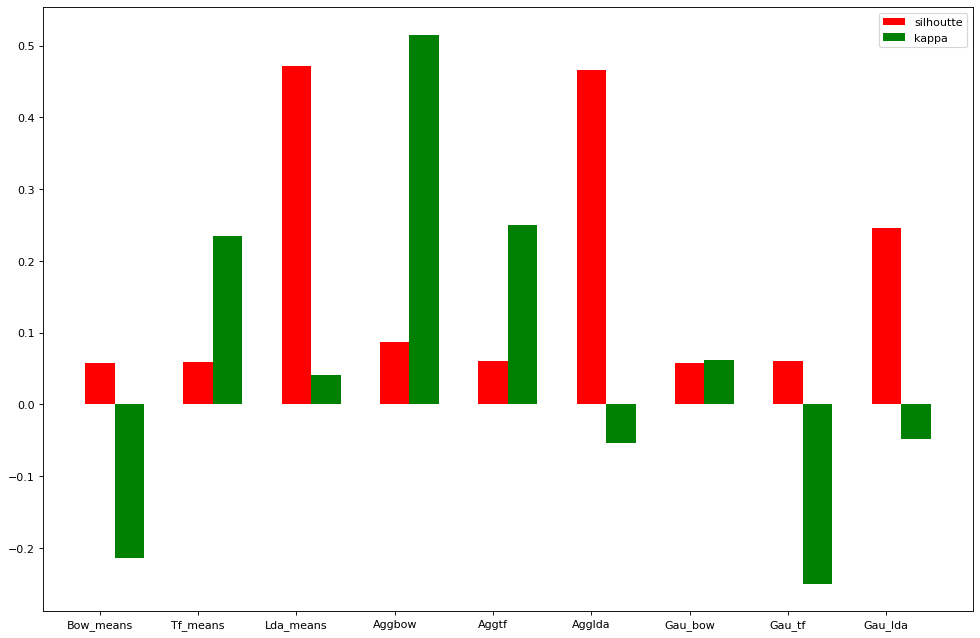

In [17]:
#Bar graph
from sklearn.metrics import cohen_kappa_score
kappa_bow_kmeans=cohen_kappa_score(y_kmeansbow, yvec)
kappa_tf_kmeans=cohen_kappa_score(y_kmeanstf, yvec)
kappa_lda_kmeans=cohen_kappa_score(y_kmeanslda, yvec)
kappa_agg_bow=cohen_kappa_score(y_hcbow, yvec)
kappa_agg_tf=cohen_kappa_score(y_hctf, yvec)
kappa_agg_lda=cohen_kappa_score(y_hclda, yvec)
kappa_gau_bow=cohen_kappa_score(gaussianpredbow, yvec)
kappa_gau_tf=cohen_kappa_score(gaussianpred, yvec)
kappa_gau_lda=cohen_kappa_score(gaussianpredlda, yvec)

sil_df = [silhouette_bow_kmeans,silhouette_tf_kmeans,silhouette_lda_kmeans,silhouette_agg_bow,silhouette_agg_tf, silhouette_agg_lda, silhouette_gaubow, silhouette_gautf, silhouette_gaulda]
kappa_df = [kappa_bow_kmeans,kappa_tf_kmeans,kappa_lda_kmeans,kappa_agg_bow,kappa_agg_tf,kappa_agg_lda,kappa_gau_bow,kappa_gau_tf,kappa_gau_lda]
 
N = 9
indi = np.arange(N)

from matplotlib.pyplot import figure
figure(figsize=(15, 10), dpi=80)

plt.bar(indi, sil_df, width = 0.3, color='r', align = 'center', label = 'silhoutte')
plt.bar(indi+0.3, kappa_df, width = 0.3, color='g', align = 'center', label = 'kappa')
 
plt.xticks(indi+0.3)
plt.xticks(np.arange(N),('Bow_means', 'Tf_means', 'Lda_means', 'Aggbow', 'Aggtf', 'Agglda', 'Gau_bow', 'Gau_tf', 'Gau_lda'))
plt.legend()

In [18]:
#Kappa score
print('kappa for bow and kmeans is %s ' %cohen_kappa_score(y_kmeansbow, yvec))
print('kappa for tf and kmeans is %s '%cohen_kappa_score(y_kmeanstf, yvec))
print('kappa for lda and kmeans is %s '%cohen_kappa_score(y_kmeanslda, yvec))
print('kappa for bow and agg is %s '%cohen_kappa_score(y_hcbow, yvec))
print('kappa for tf and agg is %s '%cohen_kappa_score(y_hctf, yvec))
print('kappa for lda and agg is %s '%cohen_kappa_score(y_hclda, yvec))
print('kappa for bow and gauss is %s '%cohen_kappa_score(gaussianpredbow, yvec))
print('kappa for tf and gauss is %s '%cohen_kappa_score(gaussianpred, yvec))
print('kappa for lda and gauss is %s '%cohen_kappa_score(gaussianpredlda, yvec))

#ARI
adjusted_rand_score(yvec, y_kmeanstf)
adjusted_rand_score(yvec, y_kmeansbow)
adjusted_rand_score(yvec, y_kmeanslda)

adjusted_rand_score(yvec, gaussianpred)
adjusted_rand_score(yvec, gaussianpredbow)
adjusted_rand_score(yvec, gaussianpredlda)

kappa for bow and kmeans is -0.2137500000000001 
kappa for tf and kmeans is 0.235 
kappa for lda and kmeans is 0.04125000000000001 
kappa for bow and agg is 0.515 
kappa for tf and agg is 0.25 
kappa for lda and agg is -0.053749999999999964 
kappa for bow and gauss is 0.06125000000000003 
kappa for tf and gauss is -0.25 
kappa for lda and gauss is -0.0475000000000001 


0.37460972081074556

In [19]:
def vectorize2():
    # Creating a corpus of all 5 books
    corpus = []
    for i in range(0, 1000):
        review = re.sub('[^a-zA-Z]',' ', df_x['partition'][i]) #this will only keep letters from A-z and will remove any numbers and puntuation
        review = review.lower()# this will convert all letters to lower cases
        reviewer = " ".join(review.split())# remove white spaces
        corpus.append(reviewer)
    
    # Creating the Bags of Words Model
    CountVec = CountVectorizer(ngram_range=(1,1))
    #transform
    Count_data = CountVec.fit_transform(corpus)
    #create dataframe
    BOW_dataframe=pd.DataFrame(Count_data.toarray())
    Y = CountVec.get_feature_names()
    
    yvec = books_df.iloc[:, 0]
    yvecs = pd.DataFrame(yvec)
    #Encoding categorical data
    from sklearn.preprocessing import LabelEncoder
    labelencoder_y = LabelEncoder()
    yvec=labelencoder_y.fit_transform(yvec)
      

    #Td-if
    X_tf = TfidfVectorizer()
    X_tfd =  X_tf.fit_transform(corpus).toarray()
    X_tfd = pd.DataFrame(X_tfd)
    
    # Applying LDA
    lda = LDA(n_components = 10, max_iter=10, n_jobs = -1, batch_size=128, learning_decay=0.5)
    lda.fit_transform(BOW_dataframe)
    X_lda2 = lda.fit_transform(X_tfd)
    X_LDa2 = pd.DataFrame(X_lda2)

    return X_LDa2,X_lda2

X_LDa2,X_lda2 =vectorize2()

Xlda2_cluster = X_LDa2.iloc[:, 0:X_lda.size].values


#kmeans with tf-idf and LDA
modelkmeanstfLDA = KMeans(n_clusters=5)
modelkmeanstfLDA.fit(Xlda2_cluster)
y_kmeanstfLDA = modelkmeanstf.fit_predict(Xlda2_cluster)
y_kmeanstfLDAs = pd.DataFrame(y_kmeanstfLDA)

silhouette_tfLDA_kmeans = (silhouette_score(Xlda2_cluster, y_kmeanstfLDA, metric='euclidean'))
kappa_tfLDA_kmeans=cohen_kappa_score(y_kmeanstfLDA, yvec)



In [20]:
silhouette_tfLDA_kmeans

0.46612485038859214

In [21]:
kappa_tfLDA_kmeans

0.04625000000000001

In [22]:
# Fitting Hierarchical Clustering to the dataset for BOW
# from sklearn.cluster import AgglomerativeClustering
hcTFLDA = AgglomerativeClustering(n_clusters=5, affinity = 'euclidean', linkage = 'ward')
y_hcTFLDA = hcTFLDA.fit_predict(Xlda2_cluster)

silhouette_tfLDA_kmeans = (silhouette_score(Xlda2_cluster, y_hcTFLDA, metric='euclidean'))
kappa_tfLDA_kmeans=cohen_kappa_score(y_hcTFLDA, yvec)

print(silhouette_tfLDA_kmeans)
print(kappa_tfLDA_kmeans)


0.3510007984579535
0.11250000000000004


In [23]:
# gaussian = mixture.GaussianMixture(n_components = 5, covariance_type = 'full')
gaussian.fit(X_lda2)
gaussianpredTFLDA = gaussian.fit_predict(X_lda2)

silhouette_tfLDA_kmeans = (silhouette_score(Xlda2_cluster, gaussianpredTFLDA, metric='euclidean'))
kappa_tfLDA_kmeans=cohen_kappa_score(gaussianpredTFLDA, yvec)

print(silhouette_tfLDA_kmeans)
print(kappa_tfLDA_kmeans)

0.07081160367016502
-0.050000000000000044


In [24]:

#ARI
print(adjusted_rand_score(yvec, y_kmeanstf)*100)
print(adjusted_rand_score(yvec, y_kmeansbow)*100)
print(adjusted_rand_score(yvec, y_kmeanslda)*100)

print(adjusted_rand_score(yvec, gaussianpred)*100)
print(adjusted_rand_score(yvec, gaussianpredbow)*100)
print(adjusted_rand_score(yvec, gaussianpredlda)*100)

print(adjusted_rand_score(yvec, y_hctf)*100)
print(adjusted_rand_score(yvec, y_hcbow)*100)
print(adjusted_rand_score(yvec, y_hclda)*100)

74.67592723935428
71.80846095792143
44.86726570308983
95.29282388493114
38.30805837733406
37.46097208107456
100.0
48.98060002209563
44.313892334698664
